In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.framework import ops

In [2]:
df = pd.read_csv('10-09.csv')

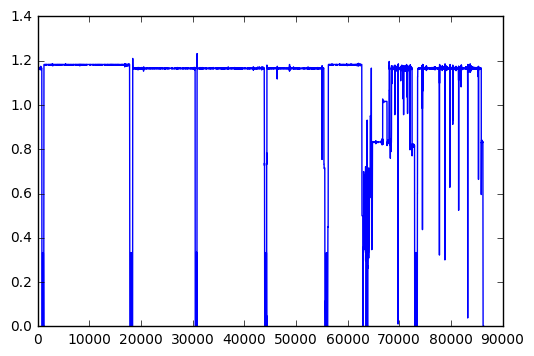

In [3]:
plt.plot(df['Tag1'])
plt.show()

In [4]:
raw_data = pd.DataFrame.as_matrix(df)

In [5]:
#Removing the time Colmn and labels
data = raw_data[:,1:-1]
labels = raw_data[:,-1]

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

/home/peyush/DeepLearning/tfEnv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
def sample_batch(X_train,y_train,batch_size,num_steps):
    """ Function to sample a batch for training"""
    N,data_len = X_train.shape
    ind_N = np.random.choice(N,batch_size,replace=False)
    ind_start = np.random.choice(data_len-num_steps,1)
    X_batch = X_train[ind_N,ind_start:ind_start+num_steps]
    y_batch = y_train[ind_N]
    return X_batch,y_batch

In [8]:
def check_test(X_test,y_test,batch_size,num_steps):
    """ Function to check the test_accuracy on the entire test set"""
    N = X_test.shape[0]
    num_batch = np.floor(N/batch_size)
    test_acc = np.zeros(num_batch)
    for i in range(int(num_batch)):
        X_batch, y_batch = sample_batch(X_test,y_test,batch_size,num_steps)
        test_acc[i] = sess.run(accuracy,feed_dict = {input_data: X_batch, targets: y_batch,keep_prob:1})
    return np.mean(test_acc)



In [9]:
val_size = int(len(data) * 0.2)
X_val, y_val  = data[len(data) - val_size:len(data), :], labels[len(labels) - val_size:len(labels)]
data = data[0:len(data)-val_size,:]
labels = labels[0:len(labels) - val_size]

In [10]:
len(labels)

69120

In [11]:
#Gatting TEst set
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
X_train, X_test = data[0:train_size,:], data[train_size:len(data),:]
y_train, y_test = labels[0:train_size], labels[train_size:len(labels)]
print(len(X_train), len(X_test))

(46310, 22810)


In [12]:
num_classes = len(np.unique(labels))
def dense_to_one_hot(labels_dense, num_classes=num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    labels_dense = np.array(labels_dense, dtype=int)
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [13]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object)

In [14]:
"""Hyperparamaters"""
max_grad_norm = 5           #Clipping of the gradient before update
num_layers = 1              #Number of stacked LSTM layers
num_steps = 7              #Number of steps to backprop over at every batch
hidden_size = 13            #Number of entries of the cell state of the LSTM
max_iterations = 2000       #Maximum iterations to train
batch_size = 40             #Batch size
dropout = 0.8               #Keep probability of the dropout wrapper

In [15]:
N = X_train.shape[0]
Ntest = X_test.shape[0]

In [16]:
# Collect the costs in a numpy fashion
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))
perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))


"""Place holders"""
input_data = tf.placeholder(tf.float32, [None, num_steps], name = 'input_data')
targets = tf.placeholder(tf.int64, [None], name='Targets')
keep_prob = tf.placeholder("float", name = 'Drop_out_keep_prob')

with tf.name_scope("LSTM_setup") as scope:
    cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)
    #We have only one input dimension, but we generalize our code for future expansion
    inputs = tf.expand_dims(input_data, 2)
    tf.Print(inputs, [inputs])

Train with approximately 1 epochs


In [17]:
inputs[:,2,:]

<tf.Tensor 'strided_slice:0' shape=(?, 1) dtype=float32>

In [18]:
#Define the recurrent nature of the LSTM
with tf.name_scope("LSTM") as scope:
    outputs = []
    state = initial_state
    with tf.variable_scope("LSTM_state"):
        for time_step in range(num_steps):
            if time_step > 0: tf.get_variable_scope().reuse_variables() #Re-use variables only after first time-step
            (cell_output, state) = cell(inputs[:, time_step, :], state)
            outputs.append(cell_output)       #Now cell_output is size [batch_size x hidden_size]
    output = tf.reduce_mean(tf.pack(outputs),0)

In [19]:
a = np.array([[[1],[3]],[[5],[7]]])
output

<tf.Tensor 'LSTM/Mean:0' shape=(40, 13) dtype=float32>

In [20]:
#Generate a classification from the last cell_output
#Note, this is where timeseries classification differs from sequence to sequence
#modelling. We only output to Softmax at last time step
with tf.name_scope("Softmax") as scope:
    with tf.variable_scope("Softmax_params"):
        softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes])
        softmax_b = tf.get_variable("softmax_b", [num_classes])
    logits = tf.nn.xw_plus_b(output, softmax_w, softmax_b)
    #Use sparse Softmax because we have mutually exclusive classes
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits,targets,name = 'Sparse_softmax')
    cost = tf.reduce_sum(loss) / batch_size
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(logits,1),targets)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [21]:
"""Optimizer"""
with tf.name_scope("Optimizer") as scope:
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),max_grad_norm)   #We clip the gradients to prevent explosion
    optimizer = tf.train.AdamOptimizer(5e-3)
    gradients = zip(grads, tvars)
    train_op = optimizer.apply_gradients(gradients)
    # Add histograms for variables, gradients and gradient norms.
    # The for-loop loops over all entries of the gradient and plots
    # a histogram. We cut of
    for gradient, variable in gradients:
        grad_values = ""
        if isinstance(gradient, ops.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        h1 = tf.histogram_summary(variable.name, variable)
        h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
        h3 = tf.histogram_summary(variable.name + "/gradient_norm", tf.global_norm([grad_values]))

In [22]:
#Final code for the TensorBoard
merged = tf.merge_all_summaries()

"""Session time"""
sess = tf.Session() #Depending on your use, do not forget to close the session
writer = tf.train.SummaryWriter("log_tb")
sess.run(tf.initialize_all_variables())

In [23]:
X_train.shape

(46310, 9)

In [24]:
step = 0
cost_train_ma = -np.log(1/float(num_classes)+1e-9)  #Moving average training cost
for i in range(max_iterations):
    # Calculate some sizes
    N = X_train.shape[0]
    #Sample batch for training
    X_batch, y_batch = sample_batch(X_train,y_train,batch_size,num_steps)

    #Next line does the actual training
    cost_train, _ = sess.run([cost, train_op],
                             feed_dict = {input_data: X_batch,targets: y_batch,keep_prob:dropout})
    cost_train_ma = cost_train_ma*0.99 + cost_train*0.01
    if i%100 == 0:
        #Evaluate training performance
        perf_collect[0,step] = cost_train

        #Evaluate validation performance
        X_batch, y_batch = sample_batch(X_val,y_val,batch_size,num_steps)
        result = sess.run([cost,merged,accuracy],
                          feed_dict = {input_data: X_batch, targets: y_batch, keep_prob:1})
        cost_val = result[0]
        perf_collect[1,step] = cost_val
        acc_val = result[2]
        perf_collect[2,step] = acc_val
        print('At %5.0f out of %5.0f: Cost is TRAIN%.3f(%.3f) VAL%.3f and val acc is %.3f'
              %(i,max_iterations,cost_train,cost_train_ma,cost_val,acc_val))


        #Write information to TensorBoard
        summary_str = result[1]
        writer.add_summary(summary_str, i)
        writer.flush()

        step +=1
acc_test = check_test(X_test,y_test,batch_size,num_steps)

/home/peyush/DeepLearning/tfEnv/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


At     0 out of  2000: Cost is TRAIN2.072(2.196) VAL2.348 and val acc is 0.000
At   100 out of  2000: Cost is TRAIN0.938(1.569) VAL1.287 and val acc is 0.625
At   200 out of  2000: Cost is TRAIN1.264(1.233) VAL0.968 and val acc is 0.675
At   300 out of  2000: Cost is TRAIN1.045(1.085) VAL0.975 and val acc is 0.675
At   400 out of  2000: Cost is TRAIN1.132(1.019) VAL0.930 and val acc is 0.675
At   500 out of  2000: Cost is TRAIN0.796(0.985) VAL1.241 and val acc is 0.575
At   600 out of  2000: Cost is TRAIN0.973(0.970) VAL0.889 and val acc is 0.800
At   700 out of  2000: Cost is TRAIN0.803(0.947) VAL0.929 and val acc is 0.650
At   800 out of  2000: Cost is TRAIN1.020(0.954) VAL1.088 and val acc is 0.650
At   900 out of  2000: Cost is TRAIN1.010(0.959) VAL0.834 and val acc is 0.725
At  1000 out of  2000: Cost is TRAIN1.102(0.953) VAL1.103 and val acc is 0.600
At  1100 out of  2000: Cost is TRAIN0.894(0.963) VAL1.092 and val acc is 0.675
At  1200 out of  2000: Cost is TRAIN1.052(0.975) VAL

/home/peyush/DeepLearning/tfEnv/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The accuracy on the test data is 0.598


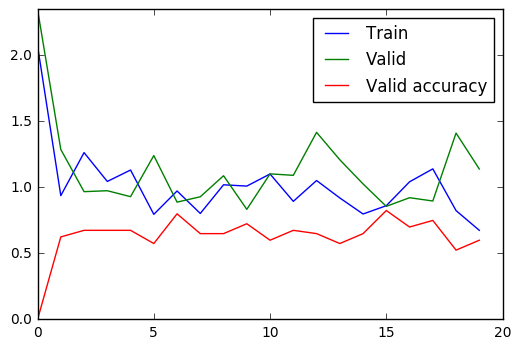

In [25]:
"""Additional plots"""
print('The accuracy on the test data is %.3f' %(acc_test))
plt.plot(perf_collect[0],label='Train')
plt.plot(perf_collect[1],label = 'Valid')
plt.plot(perf_collect[2],label = 'Valid accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()